In [1]:
import time
import matplotlib.pyplot as plt
import pyRTC.utils as utils
import numpy as np

from astropy.io import fits
from pyRTC import *

Spinnaker python SDK installation not found
Spinnaker python SDK installation not found
ximea python SDK installation not found
PI python SDK installation not found


Set up hardware

In [2]:
conf = utils.read_yaml_file("config_asmlab.yaml")
dm_conf = conf["wfc"]
wfs_conf = conf["wfs"]
slopes_conf = conf["slopes"]
loop_conf = conf["loop"]

In [4]:
# If could not read XML URL error shows up open Spinview and stop/start acquisition manually a few times
wfs = SpinnakerWFS(wfs_conf)

In [5]:
dm = ImakaDM(dm_conf)

In [6]:
slopes = SlopesProcess(conf=slopes_conf)
loop = Loop(conf=loop_conf)

Run the system

In [7]:
dm.start()
dm.flatten()
wfs.start()
slopes.start()

In [49]:
slopes.refSlopes *= 0

In [22]:
slopes.takeRefSlopes()

In [60]:
slopes.refSlopesFile = "/home/imaka/asm/pyrtc/pyRTC-IRTF/IRTF/calib/refSlopes_12x12.npy"

In [61]:
slopes.loadRefSlopes()

In [24]:
slopes.saveRefSlopes()

In [24]:
wfs.takeDark()

In [21]:
slopes.imageNoise = 2000
slopes.contrast = 5

In [25]:
wfs.saveDark()

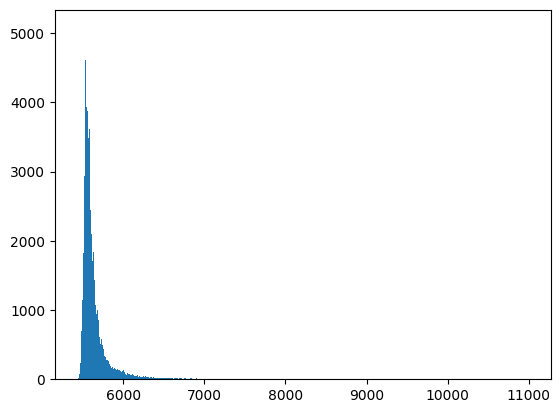

In [30]:
plt.figure()
plt.hist(wfs.dark.flatten(), bins=1000)
plt.show()

In [28]:
loop.pokeAmp = 0.02
loop.numItersIM = 500

In [29]:
loop.computeIM()
dm.flatten()

In [32]:
loop.loadIM("/home/imaka/asm/pyrtc/pyRTC-IRTF/IRTF/calib/imat.12x12.zernike.20250910c.npy")

In [30]:
loop.saveIM("/home/imaka/asm/pyrtc/pyRTC-IRTF/IRTF/calib/imat.12x12.zernike.20250910c.npy")

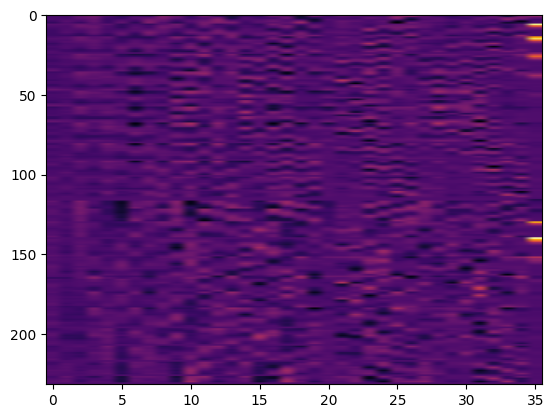

In [33]:
loop.plotIM()

In [23]:
testcmd = np.random.normal(0, 0.01, size=(36))

In [9]:
dm.CAP = 0.08

In [ ]:
testcmd

In [62]:
testcmd = np.zeros(35)
testcmd[0] = 0

testcmd = np.random.normal(0, 0.01, size=(35))
dm.write(testcmd)
dm.sendToHardware()

In [63]:
loop.leakyGain = 0.05
loop.setGain(0.2)

In [64]:
loop.start()

In [65]:
# Open the loop
loop.stop()
time.sleep(1e-1)
dm.flatten()

Inspect data

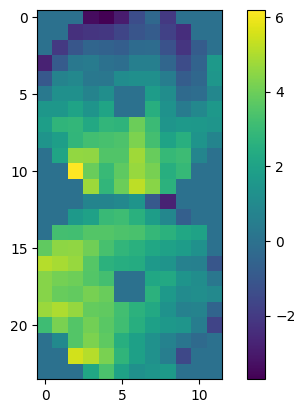

In [16]:
plt.imshow(slopes.signal2D.read_noblock())
plt.colorbar()
plt.show()

Shut down

In [66]:
wfs.stop()
dm.stop()
slopes.stop()
loop.stop()

In [44]:
del(wfs)
del(dm)
del(slopes)
del(loop)

In [2]:
shm_names = ["wfs", "wfsRaw", "wfc", "wfc2D", "signal", "signal2D", "psfShort", "psfLong"] #list of SHMs to reset
clear_shms(shm_names)

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/resource_tracker.py", line 209, in main
    cache[rtype].remove(name)
KeyError: '/wfs'
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/resource_tracker.py", line 209, in main
    cache[rtype].remove(name)
KeyError: '/wfs_meta'
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/resource_tracker.py", line 209, in main
    cache[rtype].remove(name)
KeyError: '/wfs_gpu_handle'
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/resource_tracker.py", line 209, in main
    cache[rtype].remove(name)
KeyError: '/wfsRaw'
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/resource_tracker.py", line 209, in main
    cache[rtype].remove(name)
KeyError: '/wfsRaw_meta'
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/resource_tracker.py", line 209, in main
    cache[rtype].remove(

Piston filter the imat

In [39]:
imat = np.load("/home/imaka/asm/pyrtc/pyRTC-IRTF/IRTF/calib/imat.12x12.20250910b.npy")

In [19]:
z2a = fits.getdata("/home/imaka/asm/pyrtc/pyRTC-IRTF/IRTF/calib/z2a.20240409b.fits")
a2z = np.linalg.pinv(z2a)

In [20]:
z2a[:,:35].shape

(36, 35)

In [21]:
np.save("/home/imaka/asm/pyrtc/pyRTC-IRTF/IRTF/calib/m2a_zernike.npy", z2a[:,:35])

In [40]:
imat.shape

(232, 36)

# Rotate and scale theoretical imat

In [2]:
theor = fits.getdata("calib/imat/slopesXandY.fits")
theor = theor.reshape(7,8)
#theor = theor[:7]
theor = theor.T

In [3]:
theor.shape

(8, 7)

In [104]:
theor.shape

(2, 4, 35)

In [10]:
theor[2]

array([-3.46410162,  3.46410162, -3.46410162,  3.46410162,  3.46410162,
        3.46410162, -3.46410162, -3.46410162], dtype='>f8')

In [ ]:
theor[2].reshape

In [8]:
def rotate_imat(imat, theta):
    theta = np.radians(theta)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    R = np.array([[cos_theta, -sin_theta],
                  [sin_theta, cos_theta]])

    n_modes = imat.shape[1]
    n_subaps = imat.shape[0] // 2
    new_imat = np.zeros_like(imat)
    for i in range(n_modes):
        x_slopes = imat[:n_subaps,i]
        y_slopes = imat[n_subaps:,i]
        points = np.vstack([x_slopes, y_slopes])  # always (2, n_subaps)
        rotated_points = R @ points
        new_imat[:n_subaps,i] = rotated_points[0]
        new_imat[n_subaps:,i] = rotated_points[1]

    return new_imat

best t: 316.3636363636364


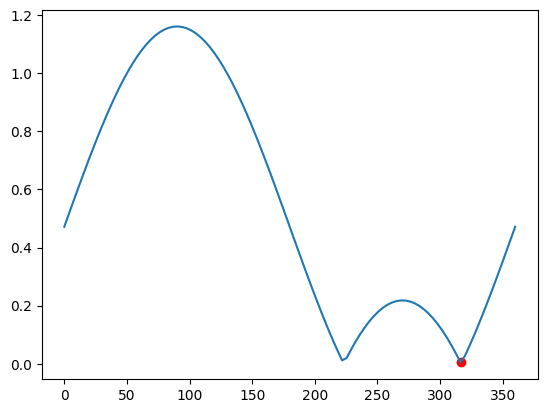

In [9]:
diff = lambda theta: np.abs( np.average(emp - rotate_imat(theor, theta)) )

Npts = 100
outputs = np.zeros(Npts)
xvals = np.linspace(0, 360, Npts)
for i in range(Npts):
    outputs[i] = diff(xvals[i])
idx = np.argmin(outputs)

best_t = xvals[idx]
best_diff = outputs[idx]
print(f"best t: {best_t}")
plt.figure()
plt.plot(xvals, outputs)
plt.scatter(best_t, best_diff, c='r')
plt.show()

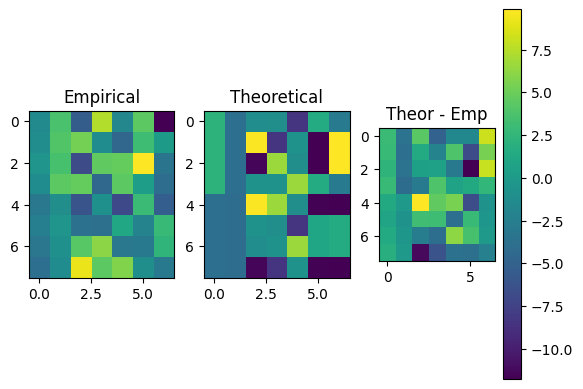

In [11]:
rot = rotate_imat(theor, best_t)
emp = np.load("calib/imat/imat.poke.20251002.c.npy")

fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(emp)
axs[0].set_title("Empirical")
axs[1].imshow(rot)
axs[1].set_title("Theoretical")
im = axs[2].imshow(rot - emp)
axs[2].set_title("Theor - Emp")
plt.colorbar(im)
plt.show()

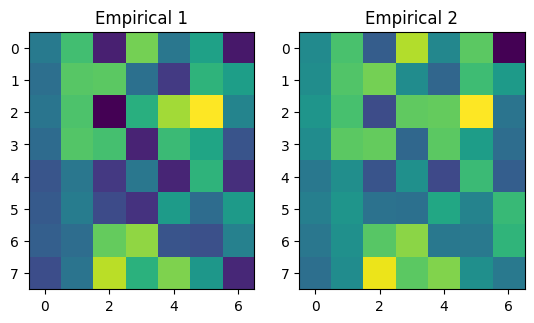

In [102]:
emp1 = np.load("calib/imat/imat.poke.20251002.b.npy")
emp2 = np.load("calib/imat/imat.poke.20251002.c.npy")

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(emp1)
axs[0].set_title("Empirical 1")
axs[1].imshow(emp2)
axs[1].set_title("Empirical 2")
plt.show()

In [83]:
make_southwell_points(2)

array([[-0.5, -0.5],
       [ 0.5, -0.5],
       [-0.5,  0.5],
       [ 0.5,  0.5]])

In [81]:
def make_southwell_points(Npts):
    """Creates an array of points that sample the pupil evenly according to the
    sampling geometry shown in Southwell (1980) Fig 1A. Radius of pupil is 1.

    Parameters
    ----------
    Npts: int
        Number of points to sample along one direction.
    
    Returns
    -------
    out: np.ndarray
        Array of points in the Southwell geometry for a SHWFS.
    """
    subap_size = 2 / Npts
    xpts = np.arange(-1 + subap_size/2, 1, subap_size)
    ypts = np.arange(-1 + subap_size/2, 1, subap_size)
    x, y = np.meshgrid(xpts, ypts, indexing="xy")
    return np.column_stack([x.ravel(), y.ravel()])